* Acquisition des données
  1. Définir la période d’étude en fonction des données disponibles via l’API et les résultats de l’analyse exploratoire (ex. : dernière année, période plus longue).
  2. Réaliser l’acquisition des données avec un script Python en interrogeant l’API.
  3. Vérifier s’il y a des valeurs manquantes. En cas de données manquantes, appliquer une interpolation linéaire.
* Transformation de la série temporelle
  1. Agréger les données pour obtenir une nouvelle série avec un pas de temps de 3 heures : la valeur à 00h sera la moyenne des valeurs mesurées à 00h, 01h et 02h ; la valeur à 03h sera la moyenne des valeurs mesurées à 03h, 04h et 05h ; et ainsi de suite.
  2. Utiliser cette série transformée dans les expérimentations.
* Analyse exploratoire
  1. Étudier les tendances, saisonnalités et résidus de la série temporelle.
  2. Visualiser la série et identifier d’éventuelles anomalies ou patterns récurrents.
* Expérimentation avec des méthodes statistiques
  1. Implémentez et documentez les expérimentations avec ARIMA, SARIMA et SARIMAX.
  2. Pour SARIMAX, explorer des variables exogènes issues de la même API.
  3. Effectuer un tuning des hyperparamètres.
* Expérimentation avec des méthodes de régression basées sur le Machine Learning
  1. Tester différentes configurations de variables explicatives : variables retardées (lag), variables construites à partir de valeurs agrégées, variables exogènes (possibilité d’utiliser la même que pour SARIMAX).
  2. Comparer plusieurs modèles de régression.
* Analyse des résidus et évaluation des performances
  1. Étudier la distribution des erreurs résiduelles.
  2. Comparer les performances des modèles sur des métriques adaptées.
  3. Documenter et interpréter les résultats obtenus.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

###Acquisition des données
 Définir la période d’étude en fonction des données disponibles via l’API et les résultats de l’analyse exploratoire (ex. : dernière année, période plus longue).
  

*Sur le site https://open-meteo.com/, les données sont disponible jusqu'au 24/03/2025. Nous allons faire notre étude sur les données des 2 dernièrs mois. Notre étude va donc se faire sur les données du 2025-01-24 au 24/03/2025.*

Réaliser l’acquisition des données avec un script Python en interrogeant l’API.

In [2]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.2 MB/s eta 0:00:00


In [3]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 43.26,
	"longitude": 1.34,
	"start_date": "2025-01-24",
	"end_date": "2025-03-24",
	"hourly": ["temperature_2m", "relative_humidity_2m"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 43.268890380859375°N 1.3452913761138916°E
Elevation 270.0 m asl
Timezone b'Europe/Berlin'b'GMT+2'
Timezone difference to GMT+0 7200 s
                          date  temperature_2m  relative_humidity_2m
0    2025-01-23 22:00:00+00:00        2.701000             94.129112
1    2025-01-23 23:00:00+00:00        3.401000             91.194405
2    2025-01-24 00:00:00+00:00        3.601000             90.884026
3    2025-01-24 01:00:00+00:00        3.301000             92.496857
4    2025-01-24 02:00:00+00:00        3.301000             89.894691
...                        ...             ...                   ...
1435 2025-03-24 17:00:00+00:00       13.401000             65.658531
1436 2025-03-24 18:00:00+00:00       11.551001             71.632538
1437 2025-03-24 19:00:00+00:00        9.851000             83.293846
1438 2025-03-24 20:00:00+00:00        9.101000             90.950363
1439 2025-03-24 21:00:00+00:00        8.801001             92.179298

[1440 rows x 3 columns]


Notre dataset contient 3 colonnes :
  - data : qui contient la date et l'heure de la mesure
  - temperature_2m :  température de l'air à 2 mètres au-dessus du sol
  - relative_humidity_2m : humidité relative à 2 mètres au-dessus du sol

Vérifier s’il y a des valeurs manquantes. En cas de données manquantes, appliquer une interpolation linéaire.

In [4]:
hourly_dataframe.isna().sum()

,0
date,0
temperature_2m,0
relative_humidity_2m,0


*Il n'y a pas de valeurs manquantes dans le dataset.*

###Transformation de la série temporelle
  1. Agréger les données pour obtenir une nouvelle série avec un pas de temps de 3 heures : la valeur à 00h sera la moyenne des valeurs mesurées à 00h, 01h et 02h ; la valeur à 03h sera la moyenne des valeurs mesurées à 03h, 04h et 05h ; et ainsi de suite.
  2. Utiliser cette série transformée dans les expérimentations.

In [5]:
hourly_dataframe['date'].dtype

datetime64[ns, UTC]

In [6]:
hourly_dataframe.set_index('date', inplace=True)

aggregated_data = hourly_dataframe.resample('3h').mean()
aggregated_data.reset_index(inplace=True)
print(aggregated_data)

                         date  temperature_2m  relative_humidity_2m
0   2025-01-23 21:00:00+00:00        3.051000             92.661758
1   2025-01-24 00:00:00+00:00        3.401000             91.091858
2   2025-01-24 03:00:00+00:00        2.001000             90.451447
3   2025-01-24 06:00:00+00:00        3.051000             84.571243
4   2025-01-24 09:00:00+00:00        8.517667             76.249878
..                        ...             ...                   ...
476 2025-03-24 09:00:00+00:00       11.434334             76.356499
477 2025-03-24 12:00:00+00:00       13.601001             62.487545
478 2025-03-24 15:00:00+00:00       13.667667             60.218689
479 2025-03-24 18:00:00+00:00       10.167666             81.958916
480 2025-03-24 21:00:00+00:00        8.801001             92.179298

[481 rows x 3 columns]


In [7]:
#mettre l'index sur date
aggregated_data.index = pd.PeriodIndex(aggregated_data.date, freq="3h")

aggregated_data.head()

,date,temperature_2m,relative_humidity_2m
date,,,
2025-01-23 21:00,2025-01-23 21:00:00+00:00,3.051000,92.661758
2025-01-24 00:00,2025-01-24 00:00:00+00:00,3.401000,91.091858
2025-01-24 03:00,2025-01-24 03:00:00+00:00,2.001000,90.451447
2025-01-24 06:00,2025-01-24 06:00:00+00:00,3.051000,84.571243
2025-01-24 09:00,2025-01-24 09:00:00+00:00,8.517667,76.249878


In [8]:
ts_meteo = aggregated_data[['temperature_2m']]
ts_meteo

,temperature_2m
date,
2025-01-23 21:00,3.051000
2025-01-24 00:00,3.401000
2025-01-24 03:00,2.001000
2025-01-24 06:00,3.051000
2025-01-24 09:00,8.517667
...,...
2025-03-24 09:00,11.434334
2025-03-24 12:00,13.601001
2025-03-24 15:00,13.667667


###Analyse exploratoire
  

Étudier les tendances, saisonnalités et résidus de la série temporelle.

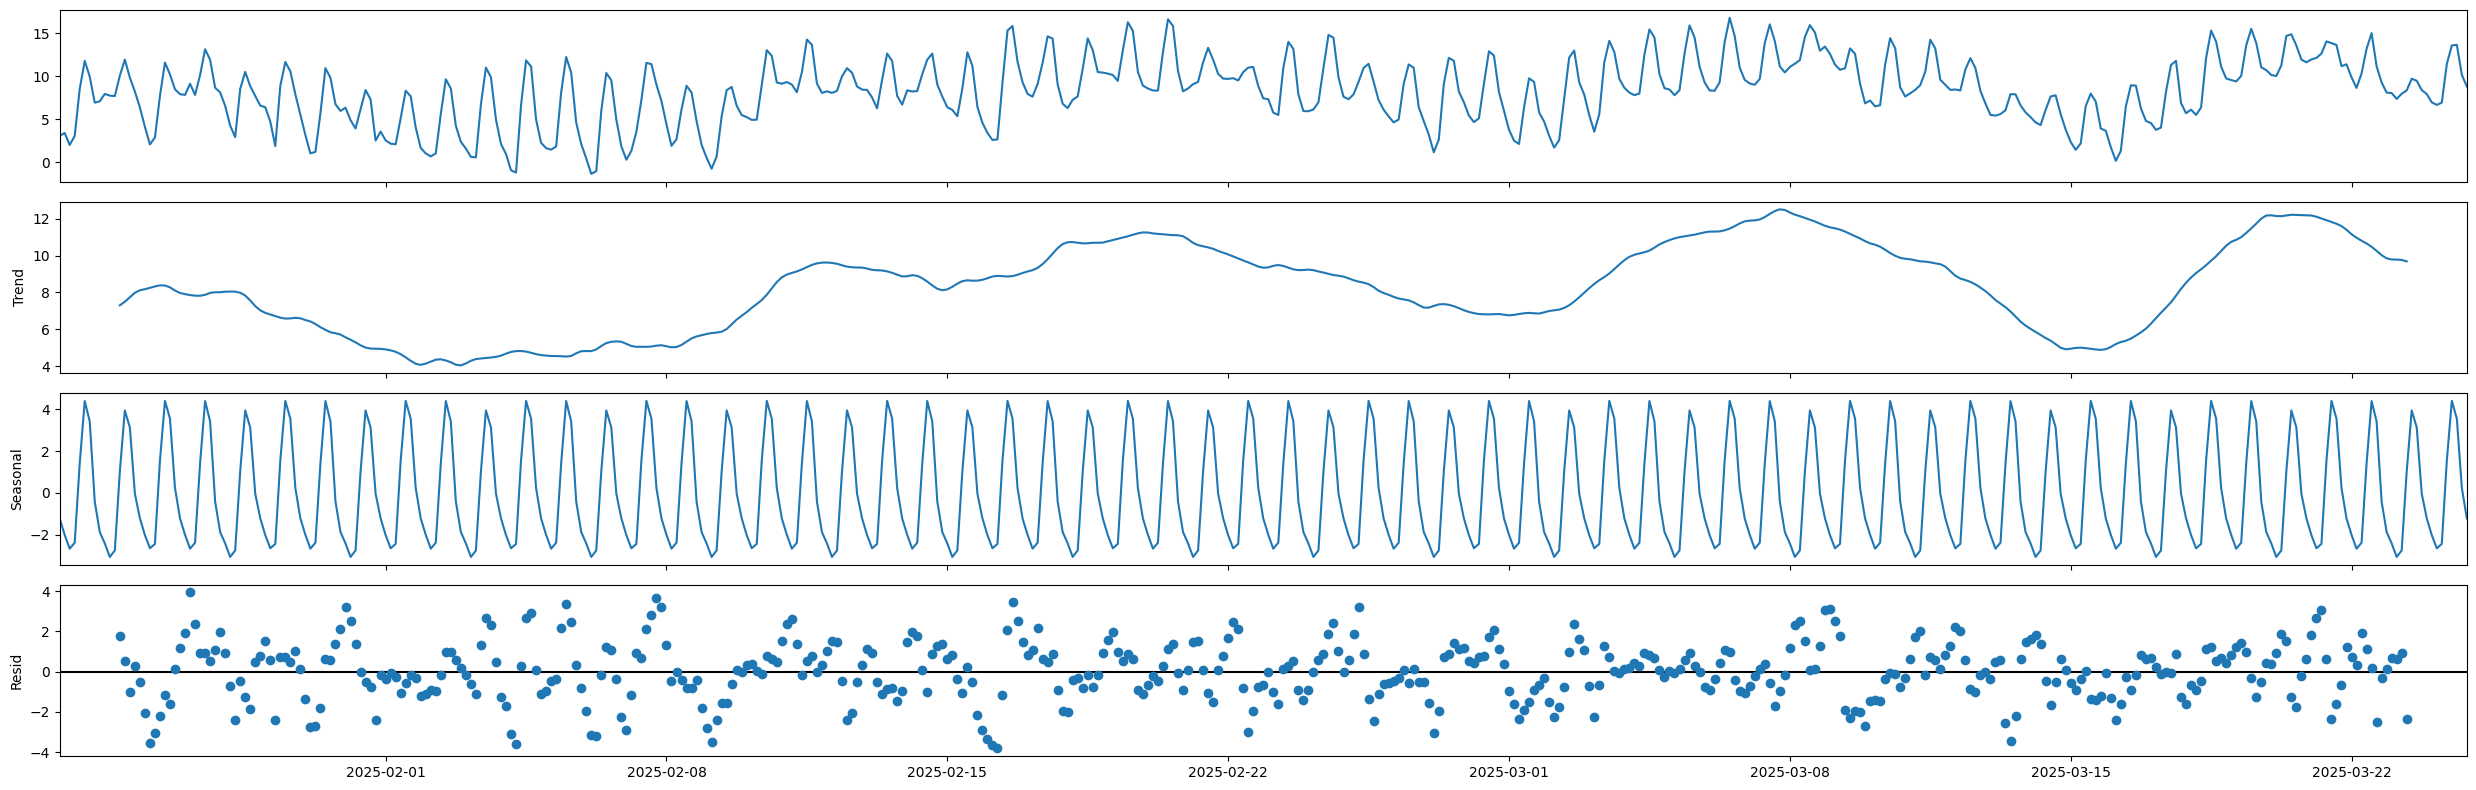

In [9]:
from statsmodels.api import tsa

ts_meteo_copy = ts_meteo.copy()
ts_meteo_copy.index = ts_meteo_copy.index.to_timestamp()
# ts_meteo_copy.index.to_period(freq='M')

# Get Trend, Seasonal, and Residuals components
res = tsa.seasonal_decompose(ts_meteo_copy)
plt.rc("figure", figsize=(25,8))
resplot = res.plot()

Visualiser la série et identifier d’éventuelles anomalies ou patterns récurrents.

<Axes: xlabel='date'>

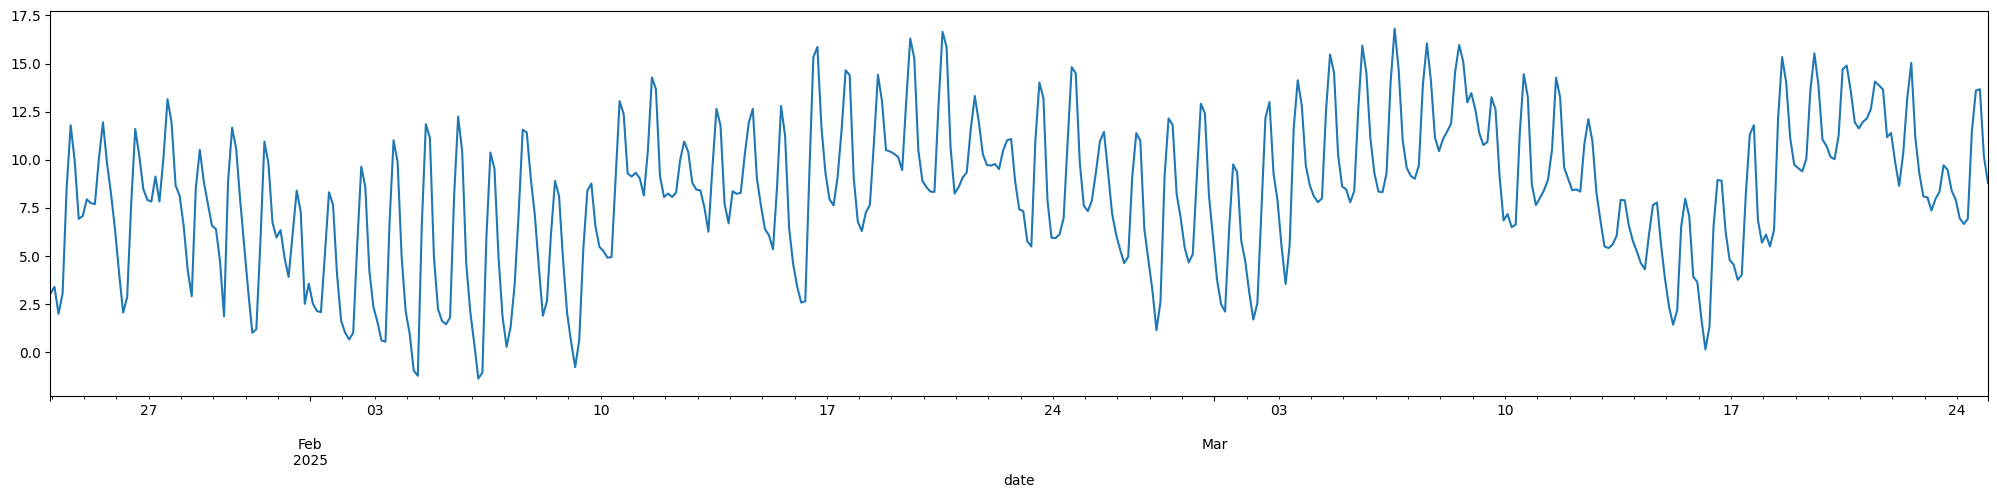

In [10]:
ts_meteo.temperature_2m.plot(figsize=(25,5))

###Expérimentation avec des méthodes statistiques


In [11]:
from statsmodels.tsa import stattools
P_VALUE_SIGNIFICANT = 0.05

def check_kpss_stat(ts):

  kpss_results = stattools.kpss(ts)
  kpss_stat = kpss_results[0]
  p_value = kpss_results[1]
  critical_values = kpss_results[3]

  print(f'The KPSS test results\
        \n  test statistic {kpss_stat:.3f},\
        \n  p-value: {p_value:.3f}\
        \n  critical values: {critical_values}')

  if (p_value < P_VALUE_SIGNIFICANT) and (kpss_stat > critical_values['5%']) and\
     (kpss_stat > critical_values['1%']) and (kpss_stat > critical_values['10%']):
      print('The time series is NOT stationary')
  else:
      print('The time series is stationary')

In [12]:
check_kpss_stat(ts_meteo)

The KPSS test results        
  test statistic 1.174,        
  p-value: 0.010        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is NOT stationary


<ipython-input-11-13312ca60b81>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_results = stattools.kpss(ts)


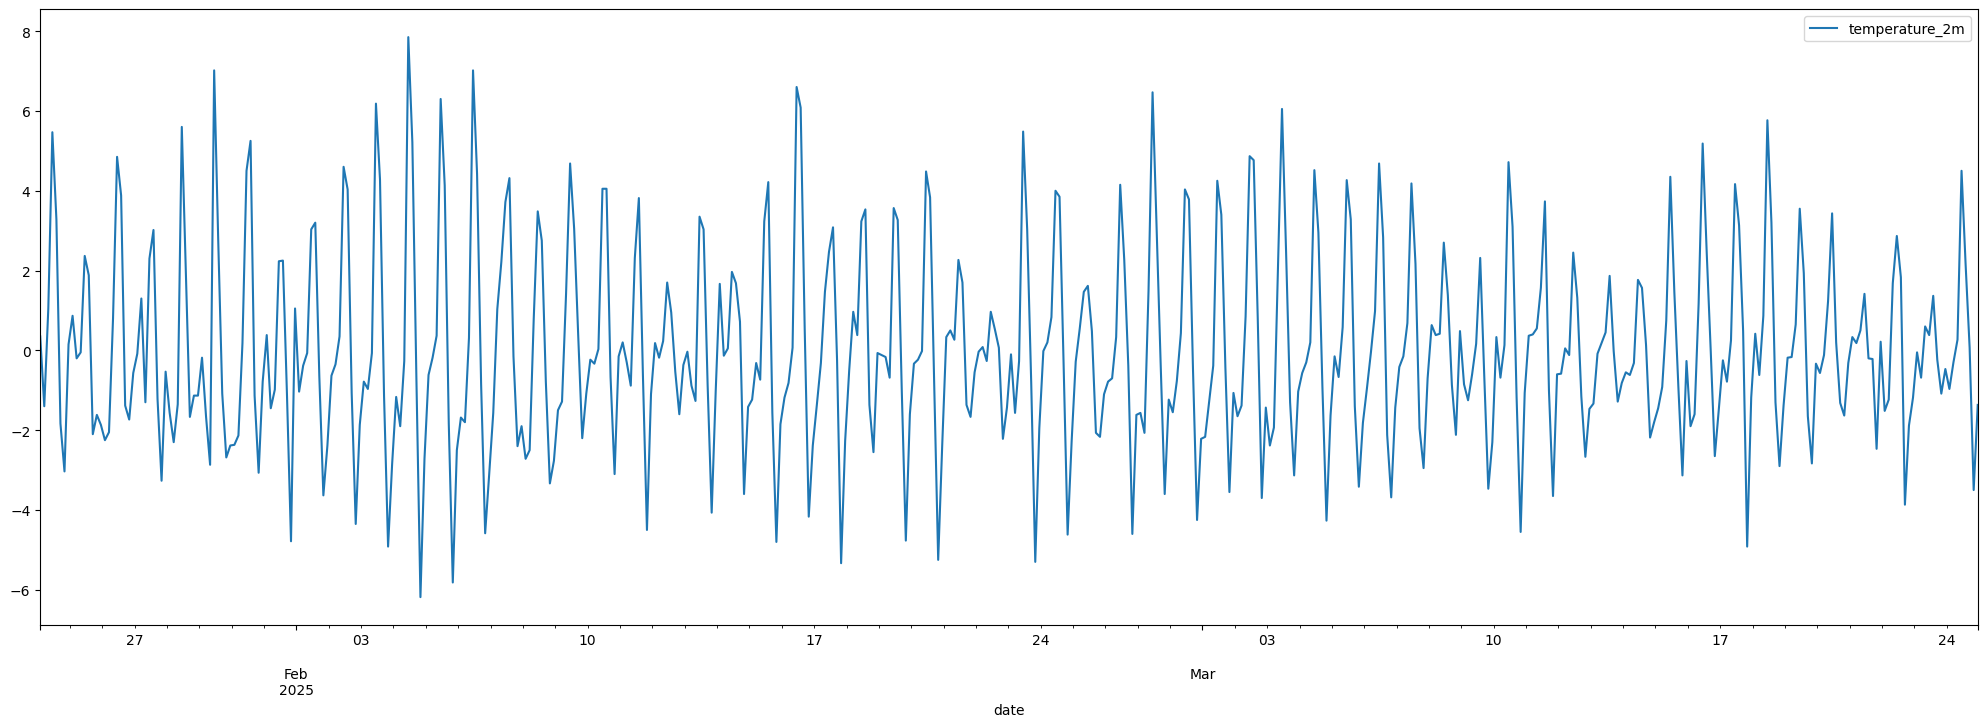

In [13]:
 #une opération de differentciation pour rendre la série stationaire
 ts_diff = (ts_meteo - ts_meteo.shift(1))
 ts_diff.dropna(inplace=True)
 ts_diff.plot();

In [14]:
check_kpss_stat(ts_diff)

The KPSS test results        
  test statistic 0.045,        
  p-value: 0.100        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary


<ipython-input-11-13312ca60b81>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_results = stattools.kpss(ts)


Implémentez et documentez les expérimentations avec ARIMA, SARIMA et SARIMAX.
  

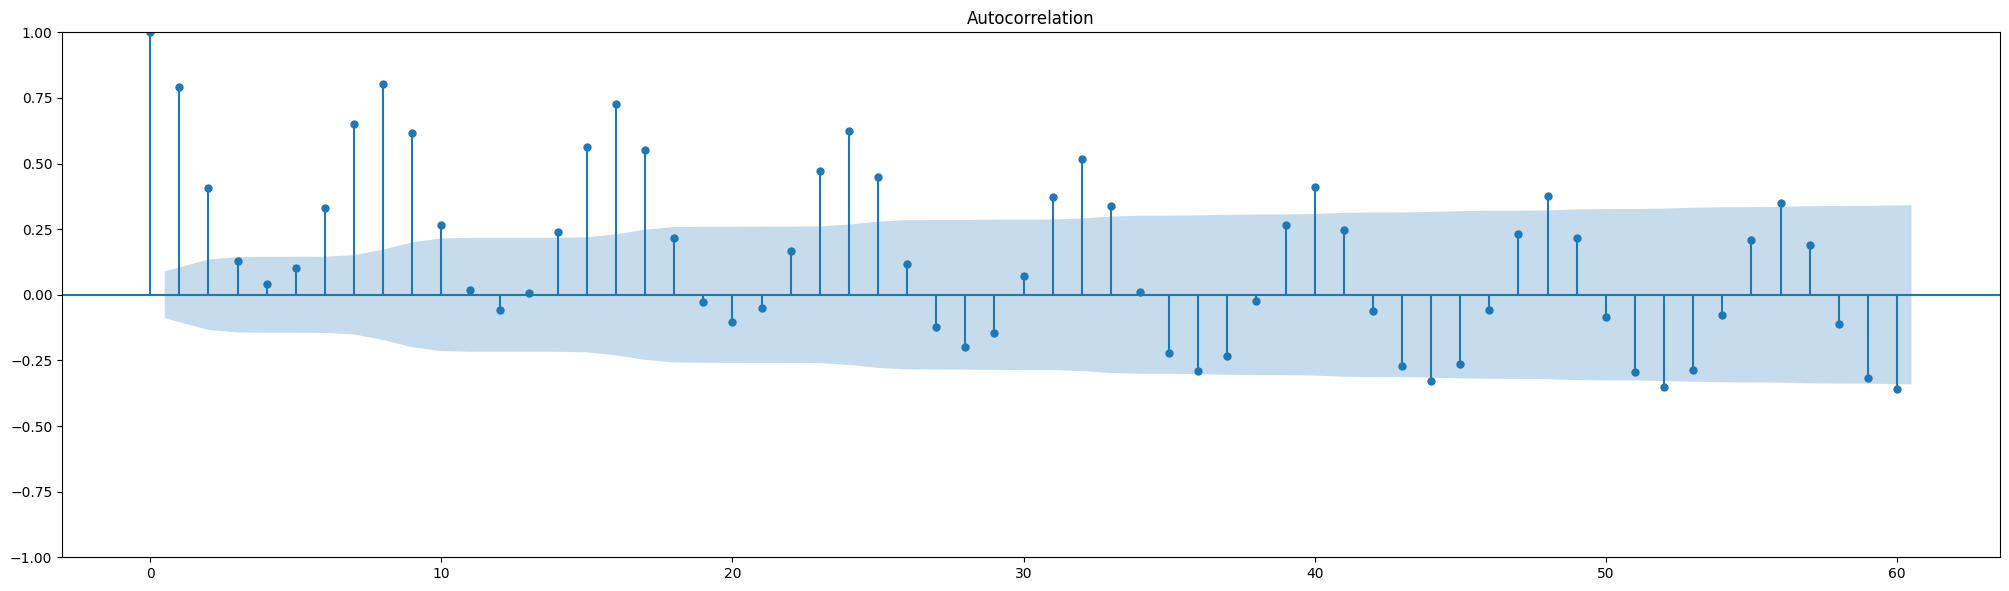

In [15]:
import statsmodels.graphics.tsaplots as tsaplots

fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(ts_meteo, lags=60, ax=ax1);

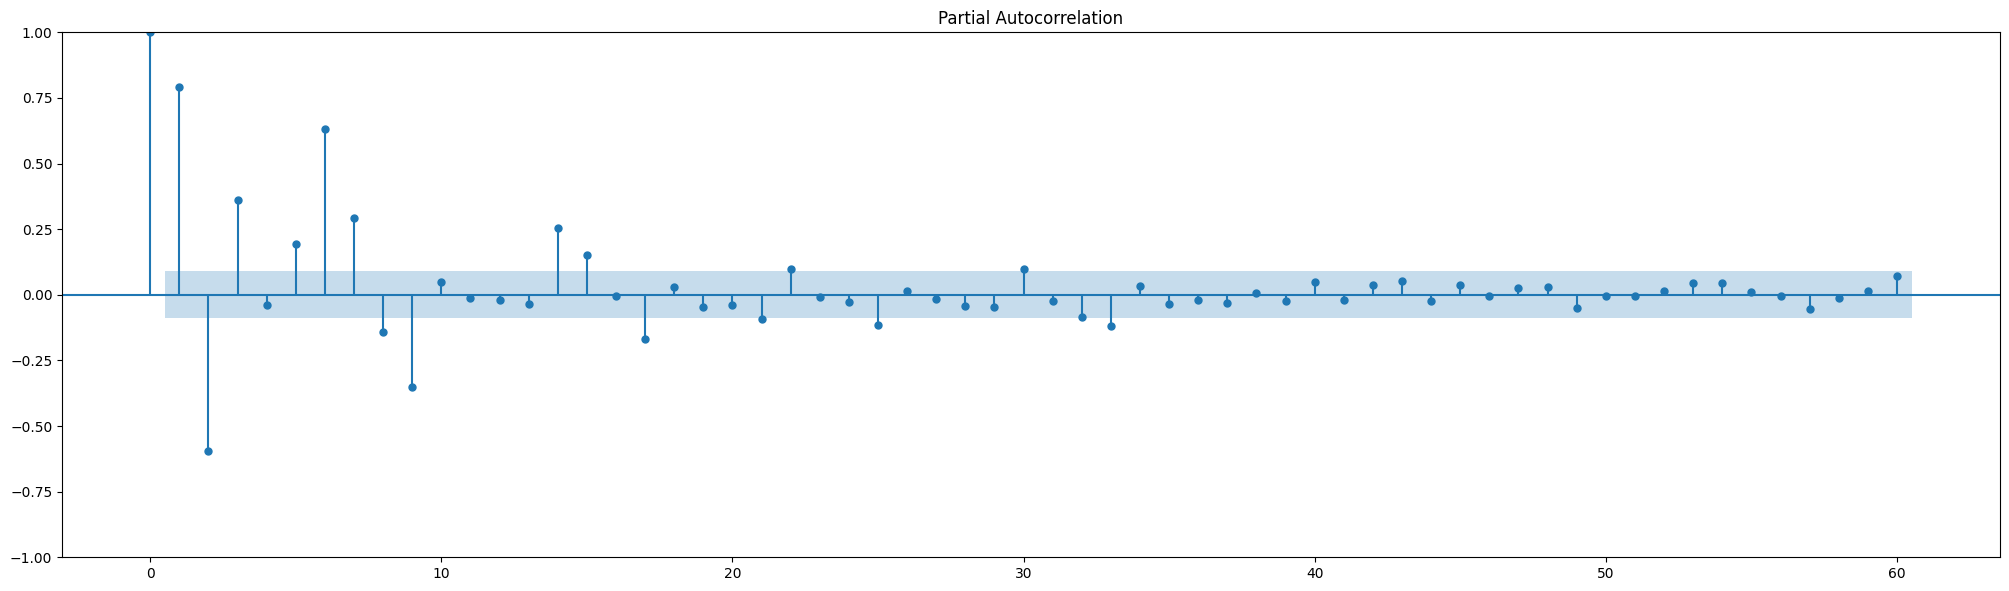

In [16]:
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_pacf(ts_meteo, lags=60, ax=ax1)

In [17]:
len_train = int(len(ts_meteo) * 0.80)
len_val = int(len(ts_meteo) * 0.1)
ind_split_1 = len_train
ind_split_2 = len_train + len_val

ts_train = ts_meteo[:ind_split_1]
ts_val = ts_meteo[ind_split_1:ind_split_2]
ts_test = ts_meteo[ind_split_2:]

ts_meteo.shape, ts_train.shape, ts_val.shape, ts_test.shape

((481, 1), (384, 1), (48, 1), (49, 1))

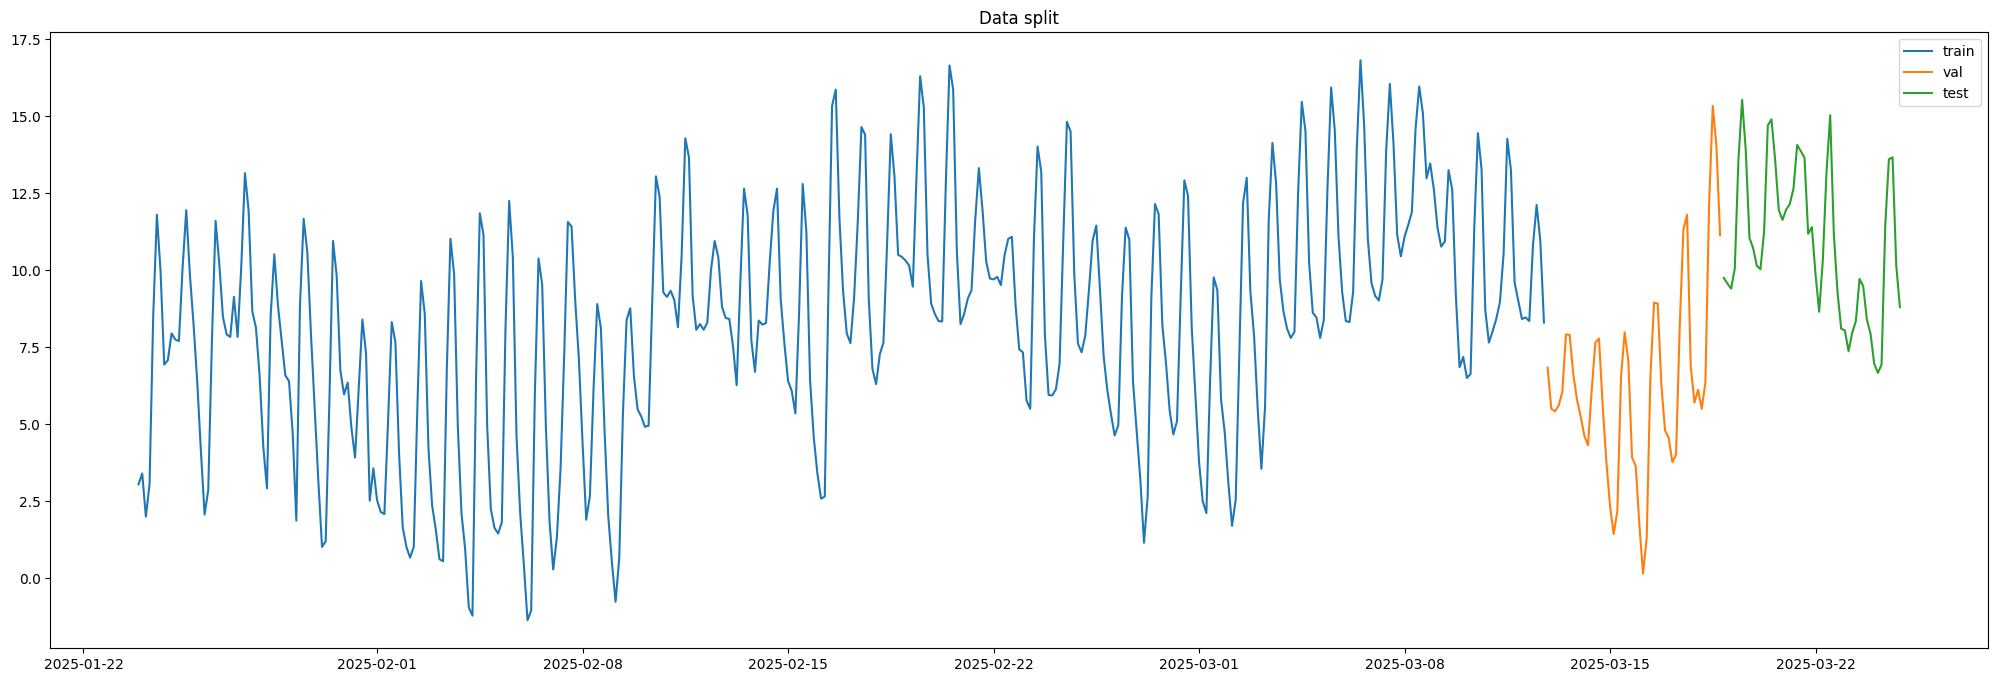

In [18]:
plt.figure()
plt.plot(ts_train.index.to_timestamp(), ts_train.values, label='train')
plt.plot(ts_val.index.to_timestamp(), ts_val.values, label='val')
plt.plot(ts_test.index.to_timestamp(), ts_test.values, label='test')
plt.legend(loc='best')
plt.title('Data split')
plt.show()

*On a effectué une differenciation pour rendre la serie stationnaire, donc d=1. à partir du acf et pacf on choisit p=9 et q=10, on obtient donc (p,d,q)=(9,1,10)*

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# p,d,q
order=(9,1,10)

model = ARIMA(ts_train, order=order).fit(method_kwargs={'maxiter':300})
print(model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                  384
Model:                ARIMA(9, 1, 10)   Log Likelihood                -542.624
Date:                Mon, 31 Mar 2025   AIC                           1125.249
Time:                        19:34:28   BIC                           1204.210
Sample:                    01-23-2025   HQIC                          1156.571
                         - 03-12-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2180      0.512      0.425      0.670      -0.786       1.222
ar.L2          0.1893      0.153      1.236      0.217      -0.111       0.490
ar.L3         -0.2751      0.041     -6.747      0.0

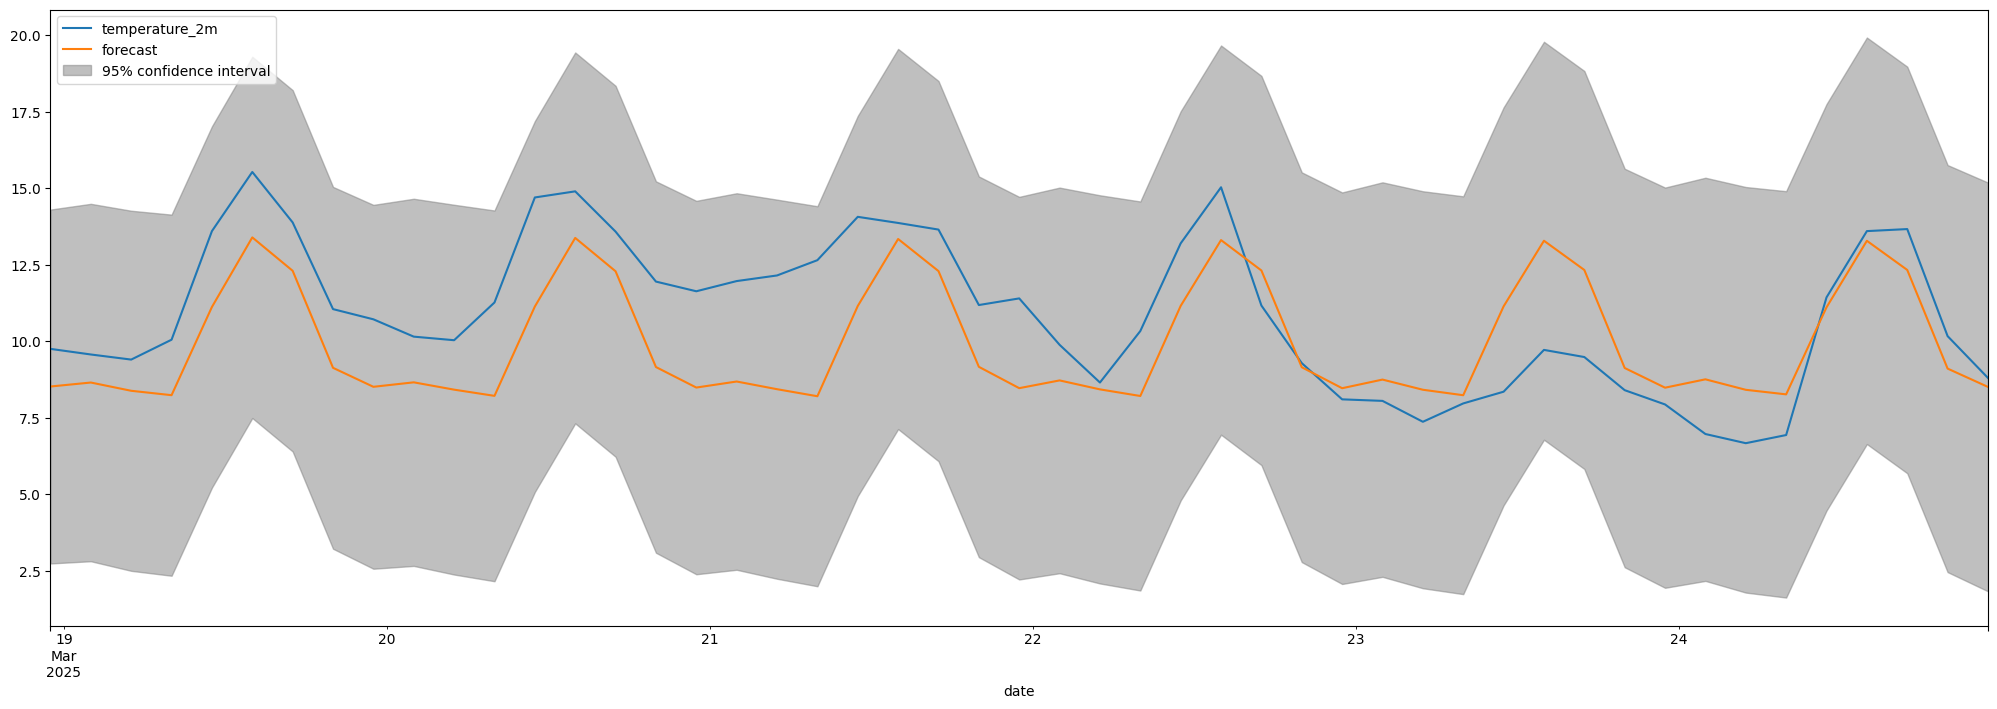

In [20]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
ax = ts_test.plot(ax=ax)
fig = plot_predict(model, start=ts_test.index[0], end=ts_test.index[-1], dynamic=False, ax=ax)
legend = ax.legend(loc="upper left")

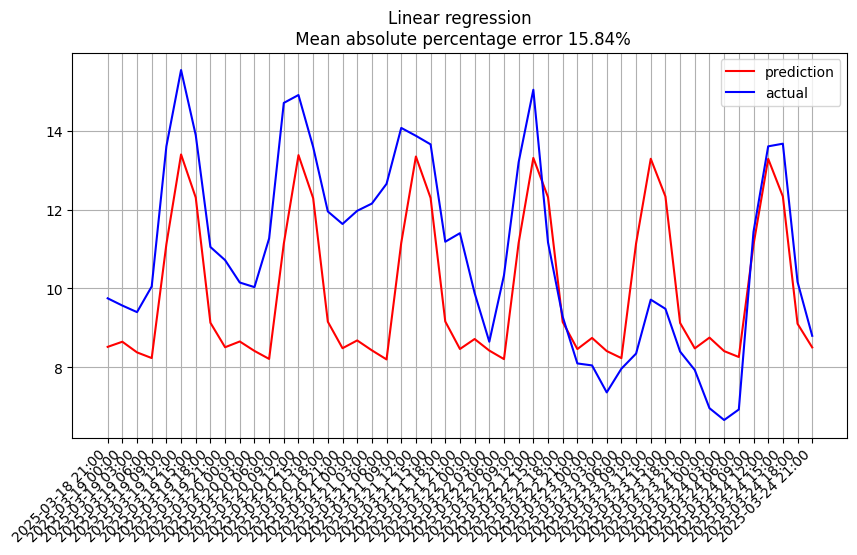

In [21]:
from sklearn.metrics import mean_absolute_percentage_error

ts_pred = model.predict(start=ts_test.index[0], end=ts_test.index[-1], dynamic=False)

y_pred = ts_pred
y_test = ts_test

# Convert the PeriodIndex to a list of strings for plotting
x_axis = [str(p) for p in y_test.index]

plt.figure(figsize=(10, 5))
# Use x_axis for the x-values in the plot
plt.plot(x_axis, y_pred, "r", label="prediction")
plt.plot(x_axis, y_test.values, "b", label="actual")  # Get the values from y_test DataFrame
plt.grid(True)
plt.legend(loc="best")
plt.xticks(rotation=45, ha='right')
plt.title(f"Linear regression\n Mean absolute percentage error {mean_absolute_percentage_error(y_test.values.ravel(), y_pred)*100:.2f}%");

In [22]:
# From PACF plot
p_params = range(0,12)
# From ACF plot
q_params = range(0,12)
d_params = range(1,2)

In [58]:
from tqdm import tqdm

best_score, best_cfg, best_model = float("inf"), None, None

nb_iterations = len(p_params) * len(d_params) * len(q_params)

with tqdm(total=nb_iterations) as pbar:
  for p in p_params:
      for d in d_params:
          for q in q_params:
              pbar.update(1)
              order = (p,d,q)
              try:
                  model = ARIMA(ts_train, order=order).fit(method_kwargs={'maxiter':300})
                  if model.aic < best_score:
                      best_score, best_cfg, best_model = model.aic, order, model
                      print(f'\nARIMA{order} AIC={model.aic:.3f}')
              except:
                  continue

print(f'\nBest ARIMA{best_cfg} AIC={best_score:.3f}')

100%|██████████| 1/1 [00:07<00:00,  7.85s/it]


ARIMA(6, 1, 7) AIC=1115.133

Best ARIMA(6, 1, 7) AIC=1115.133


In [59]:
order=(6,1,7)

model = ARIMA(ts_train, order=order).fit(method_kwargs={'maxiter':300})
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                  384
Model:                 ARIMA(6, 1, 7)   Log Likelihood                -543.567
Date:                Mon, 31 Mar 2025   AIC                           1115.133
Time:                        20:57:35   BIC                           1170.406
Sample:                    01-23-2025   HQIC                          1137.059
                         - 03-12-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1619      0.097     12.005      0.000       0.972       1.352
ar.L2         -0.8959      0.039    -23.039      0.000      -0.972      -0.820
ar.L3         -0.1423      0.055     -2.576      0.0

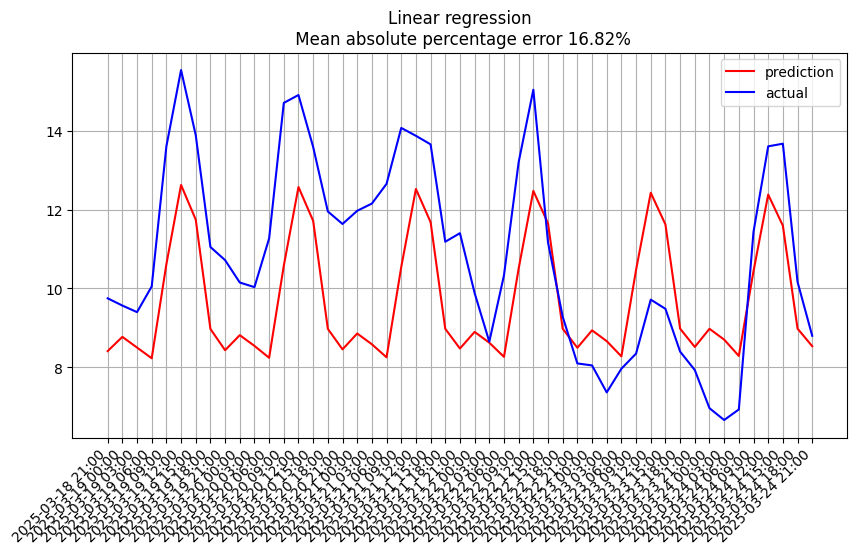

In [60]:
ts_pred = model.predict(start=ts_test.index[0], end=ts_test.index[-1], dynamic=False)

y_pred = ts_pred
y_test = ts_test

# Convert the PeriodIndex to a list of strings for plotting
x_axis = [str(p) for p in y_test.index]

plt.figure(figsize=(10, 5))
# Use x_axis for the x-values in the plot
plt.plot(x_axis, y_pred, "r", label="prediction")
plt.plot(x_axis, y_test.values, "b", label="actual")  # Get the values from y_test DataFrame
plt.grid(True)
plt.legend(loc="best")
plt.xticks(rotation=45, ha='right')
plt.title(f"Linear regression\n Mean absolute percentage error {mean_absolute_percentage_error(y_test.values.ravel(), y_pred)*100:.2f}%");

In [61]:
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

p_params = [6]
d_params = [1]
q_params = [7]

P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]

best_score_sarimax, best_cfg_sarimax, best_model_sarimax = float("inf"), None, None

# s in SARIMAX is an integer giving the periodicity (number of periods in season)
s = 8 #car 24/3.

y_test = np.exp(ts_test)

nb_iterations = len(p_params) * len(d_params) * len(q_params) *\
                len(P_params) * len(D_params) * len(Q_params)

with tqdm(total=nb_iterations) as pbar:
  for p in p_params:
      for d in d_params:
          for q in q_params:
            for P in P_params:
                for D in D_params:
                    for Q in Q_params:
                      pbar.update(1)
                      order = (p,d,q)
                      seasonal_order = (P,D,Q,s)
                      try:
                          model = SARIMAX(ts_train, order=order, seasonal_order=seasonal_order).fit(method_kwargs={'maxiter':300})
                          if model.aic < best_score_sarimax:
                              best_score_sarimax = model.aic
                              best_cfg_sarimax = {"order":order, "seasonal_order":seasonal_order}
                              best_model_sarimax = model
                              ts_pred = model.predict(start=ts_test.index[0], end=ts_test.index[-1], dynamic=False)
                              y_pred = np.exp(ts_pred)
                              mape = mean_absolute_percentage_error(y_test, y_pred)
                              print(f'\nSARIMAX(order={order}, seasonal_order={seasonal_order}): AIC={model.aic:.3f}, MAPE={mape*100:.2f}%')
                      except:
                          continue

print(f"\nBest SARIMAX(order={best_cfg_sarimax['order']}, seasonal_order={best_cfg_sarimax['seasonal_order']}), AIC={best_score_sarimax:.3f}")

  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 11%|█         | 2/18 [00:01<00:13,  1.17it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_gr


SARIMAX(order=(6, 1, 7), seasonal_order=(0, 0, 0, 8)): AIC=1118.117, MAPE=168.01%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 17%|█▋        | 3/18 [00:06<00:35,  2.38s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 22%|██▏       | 4/18 [00:10<00:44,  3.15s/it]/usr/local/lib/python3.11/dist-pac


SARIMAX(order=(6, 1, 7), seasonal_order=(0, 1, 1, 8)): AIC=1094.029, MAPE=1803.68%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 39%|███▉      | 7/18 [00:27<00:56,  5.09s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint.


SARIMAX(order=(6, 1, 7), seasonal_order=(2, 1, 1, 8)): AIC=1093.782, MAPE=2267.54%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 18/18 [01:44<00:00,  5.82s/it]


Best SARIMAX(order=(6, 1, 7), seasonal_order=(2, 1, 1, 8)), AIC=1093.782


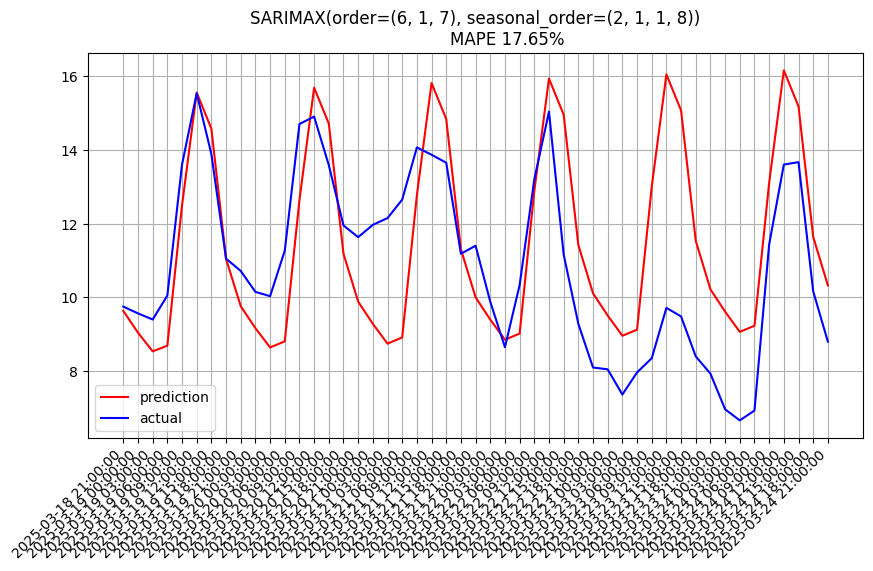

In [62]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

ts_pred = best_model_sarimax.predict(start=ts_test.index[0], end=ts_test.index[-1], dynamic=False)

y_pred = ts_pred
y_test = ts_test

# Convert the PeriodIndex to a list of strings or numeric values for plotting
x_axis = y_test.index.to_timestamp().astype(str)


plt.figure(figsize=(10, 5))

plt.plot(x_axis, y_pred.values, "r", label="prediction")
plt.plot(x_axis, y_test.values, "b", label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.xticks(rotation=45, ha='right')
mape = mean_absolute_percentage_error(y_test.values, y_pred.values)
r2 = r2_score(y_test.values, y_pred.values)
plt.title(f"SARIMAX(order={best_cfg_sarimax['order']}, seasonal_order={best_cfg_sarimax['seasonal_order']})\n\
            MAPE {mape*100:.2f}%");

Pour SARIMAX, explorer des variables exogènes issues de la même API.

In [35]:
exog_data = aggregated_data[['relative_humidity_2m']]
exog_data

,relative_humidity_2m
date,
2025-01-23 21:00,92.661758
2025-01-24 00:00,91.091858
2025-01-24 03:00,90.451447
2025-01-24 06:00,84.571243
2025-01-24 09:00,76.249878
...,...
2025-03-24 09:00,76.356499
2025-03-24 12:00,62.487545
2025-03-24 15:00,60.218689


In [51]:
len_train = int(len(exog_data) * 0.80)
len_val = int(len(exog_data) * 0.1)
ind_split_1 = len_train
ind_split_2 = len_train + len_val

exog_train = exog_data[:ind_split_1]
exog_val = exog_data[ind_split_1:ind_split_2]
exog_test = exog_data[ind_split_2:]

exog_data.shape, exog_train.shape, exog_val.shape, exog_test.shape

((481, 1), (384, 1), (48, 1), (49, 1))

In [70]:
exog_test_extended = pd.DataFrame(
    np.nan,
    index=pd.period_range(start=ts_test.index[0], periods=97, freq='3h'),  # Use pd.period_range for period data
    columns=exog_test.columns
)

# Replace missing values with existing ones from exog_test
exog_test_extended.loc[exog_test.index] = exog_test

In [72]:
exog_test_extended = exog_test_extended.ffill()

In [76]:
model_sarimax_exog = SARIMAX(ts_train, exog=exog_train, order=(6, 1, 7), seasonal_order=(2, 1, 1, 8)).fit()
ts_pred_exog = model_sarimax_exog.predict(start=ts_test.index[0], end=ts_test.index[-1], exog=exog_test_extended)
mape = mean_absolute_percentage_error(ts_test.values, ts_pred_exog.values)
print(f'SARIMAX{order}{(2, 1, 1, 8)}\nAIC={model_sarimax_exog.aic:.2f}\nMAPE (test)={mape*100:.2f}%')

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(6, 1, 7)(2, 1, 1, 8)
AIC=997.08
MAPE (test)=17.17%


####Expérimentation avec des méthodes de régression basées sur le Machine Learning
  

Tester différentes configurations de variables explicatives : variables retardées (lag), variables construites à partir de valeurs agrégées, variables exogènes (possibilité d’utiliser la même que pour SARIMAX).

- Variables retardées (lag)

In [77]:
for i in range(1, 8):
    ts_meteo[f"lag_{i}"] = ts_meteo['temperature_2m'].shift(i)
ts_meteo.head()

<ipython-input-77-25fb108ce010>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_meteo[f"lag_{i}"] = ts_meteo['temperature_2m'].shift(i)


,temperature_2m,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2025-01-23 21:00,3.051000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-24 00:00,3.401000,3.051,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-24 03:00,2.001000,3.401,3.051,NaN,NaN,NaN,NaN,NaN
2025-01-24 06:00,3.051000,2.001,3.401,3.051,NaN,NaN,NaN,NaN
2025-01-24 09:00,8.517667,3.051,2.001,3.401,3.051,NaN,NaN,NaN


In [79]:
ts_meteo.dropna(inplace=True)
ts_meteo.head()

,temperature_2m,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2025-01-24 18:00,6.934334,9.967667,11.801000,8.517667,3.051000,2.001000,3.401000,3.051000
2025-01-24 21:00,7.084333,6.934334,9.967667,11.801000,8.517667,3.051000,2.001000,3.401000
2025-01-25 00:00,7.951000,7.084333,6.934334,9.967667,11.801000,8.517667,3.051000,2.001000
2025-01-25 03:00,7.751000,7.951000,7.084333,6.934334,9.967667,11.801000,8.517667,3.051000
2025-01-25 06:00,7.701000,7.751000,7.951000,7.084333,6.934334,9.967667,11.801000,8.517667


In [80]:
from sklearn.model_selection import train_test_split

X = ts_meteo.drop('temperature_2m', axis=1)
y = ts_meteo['temperature_2m']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train.shape, X_test.shape

((402, 7), (72, 7))

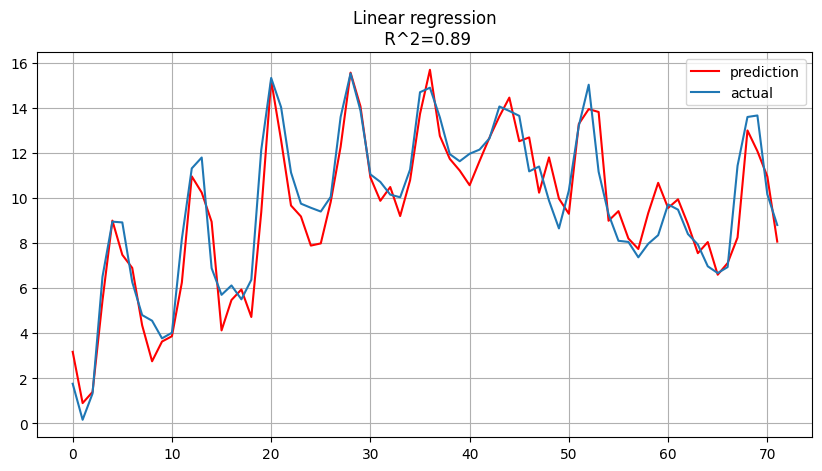

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R^2={r2_score(y_test, y_pred):.2f}");

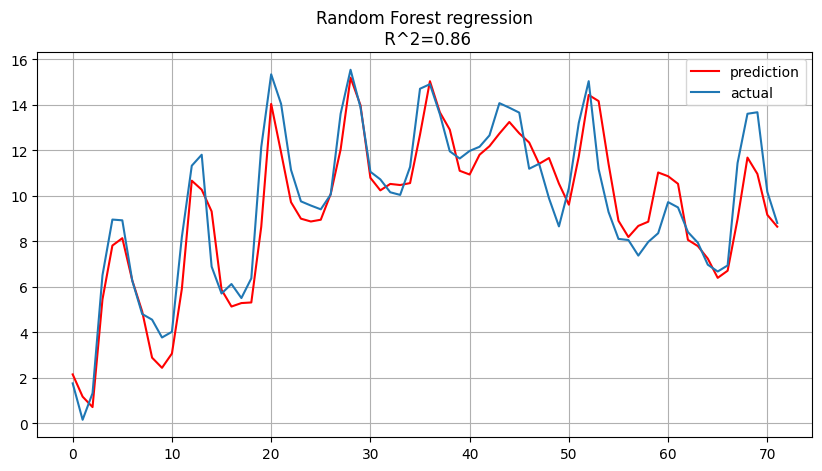

In [83]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Random Forest regression\n R^2={r2_score(y_test, y_pred):.2f}");

- Variables construites à partir de valeurs agrégées

In [84]:
def get_mean_by_cat(data, cat_feature, value_feature):
    return dict(data.groupby(cat_feature)[value_feature].mean())

In [89]:
def preprocess_data(data, lag_start=1, lag_end=8, test_size=0.15):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    data = pd.DataFrame(data.copy())

    # Ajouter des décalages temporels comme features
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['temperature_2m'].shift(i)

    # Supprimer les NaNs générés par le décalage
    data.dropna(inplace=True)

    # Ajouter une colonne pour regrouper par intervalle de 3 heures
    data["hour_3_interval"] = (data.index.hour // 3)  # Divise l'heure en intervalles de 3h

    X = data.drop('temperature_2m', axis=1)
    y = data['temperature_2m']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Calculer la moyenne des valeurs sur les intervalles de 3 heures (uniquement sur train)
    hourly_average = get_mean_by_cat(data.loc[X_train.index], "hour_3_interval", 'temperature_2m')
    X_train["hour_3_average"] = X_train["hour_3_interval"].map(hourly_average)
    X_test["hour_3_average"] = X_test["hour_3_interval"].map(hourly_average)

    # Supprimer la colonne "hour_3_interval"
    X_train.drop(["hour_3_interval"], axis=1, inplace=True)
    X_test.drop(["hour_3_interval"], axis=1, inplace=True)

    return X_train, X_test, y_train, y_test

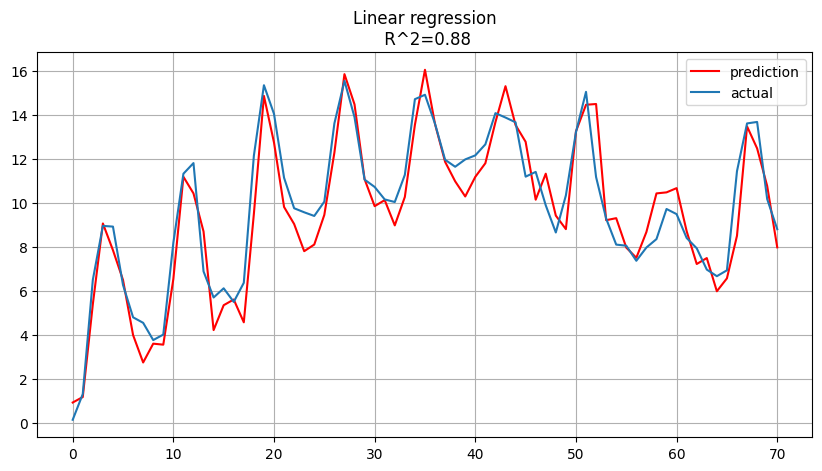

In [90]:
X_train, X_test, y_train, y_test = preprocess_data(ts_meteo)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R^2={r2_score(y_test, y_pred):.2f}");

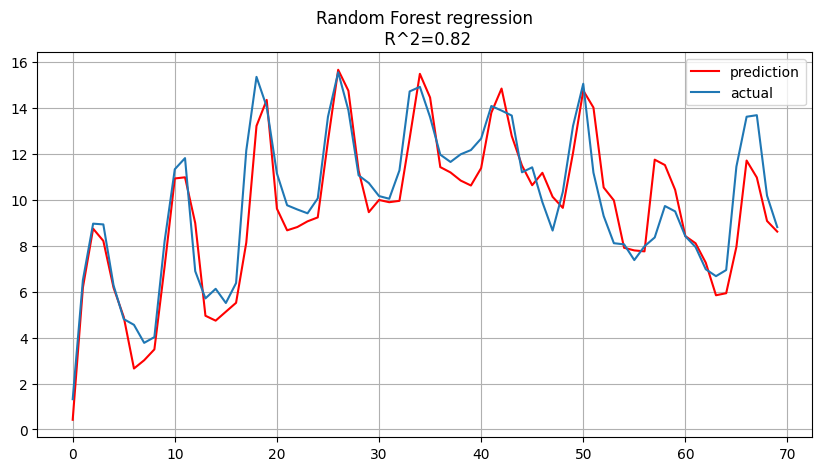

In [91]:
X_train, X_test, y_train, y_test = preprocess_data(ts_meteo, lag_end=12)

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Random Forest regression\n R^2={r2_score(y_test, y_pred):.2f}");

- variables exogènes

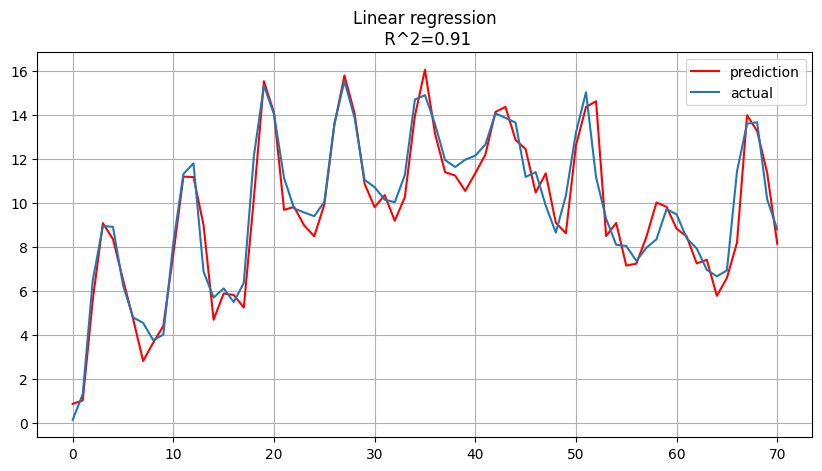

In [95]:
ts_meteo = aggregated_data[['temperature_2m','relative_humidity_2m']]

X_train, X_test, y_train, y_test = preprocess_data(ts_meteo, lag_end=12)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R^2={r2_score(y_test, y_pred):.2f}");

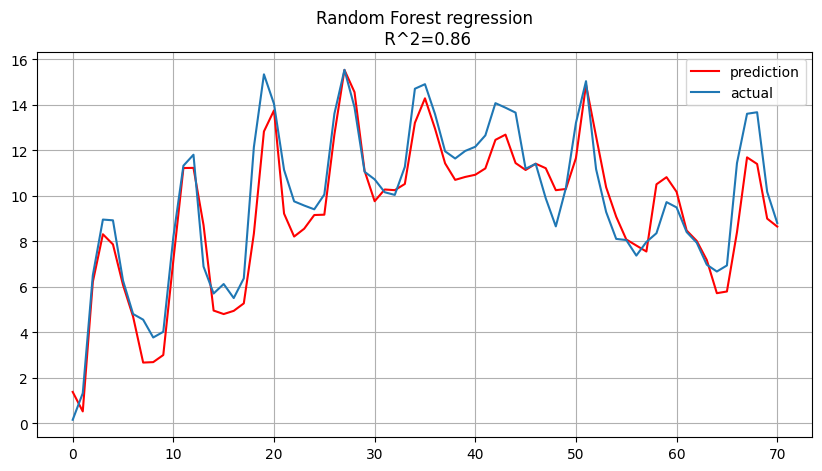

In [96]:
X_train, X_test, y_train, y_test = preprocess_data(ts_meteo, lag_end=12)

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Random Forest regression\n R^2={r2_score(y_test, y_pred):.2f}");

Comparer plusieurs modèles de régression.

*Le meilleur modèle ML pour notre time serie est la regression linéaire entraînée avec 12 lags et la variable exogène.*

####Analyse des résidus et évaluation des performances
  

Étudier la distribution des erreurs résiduelles.

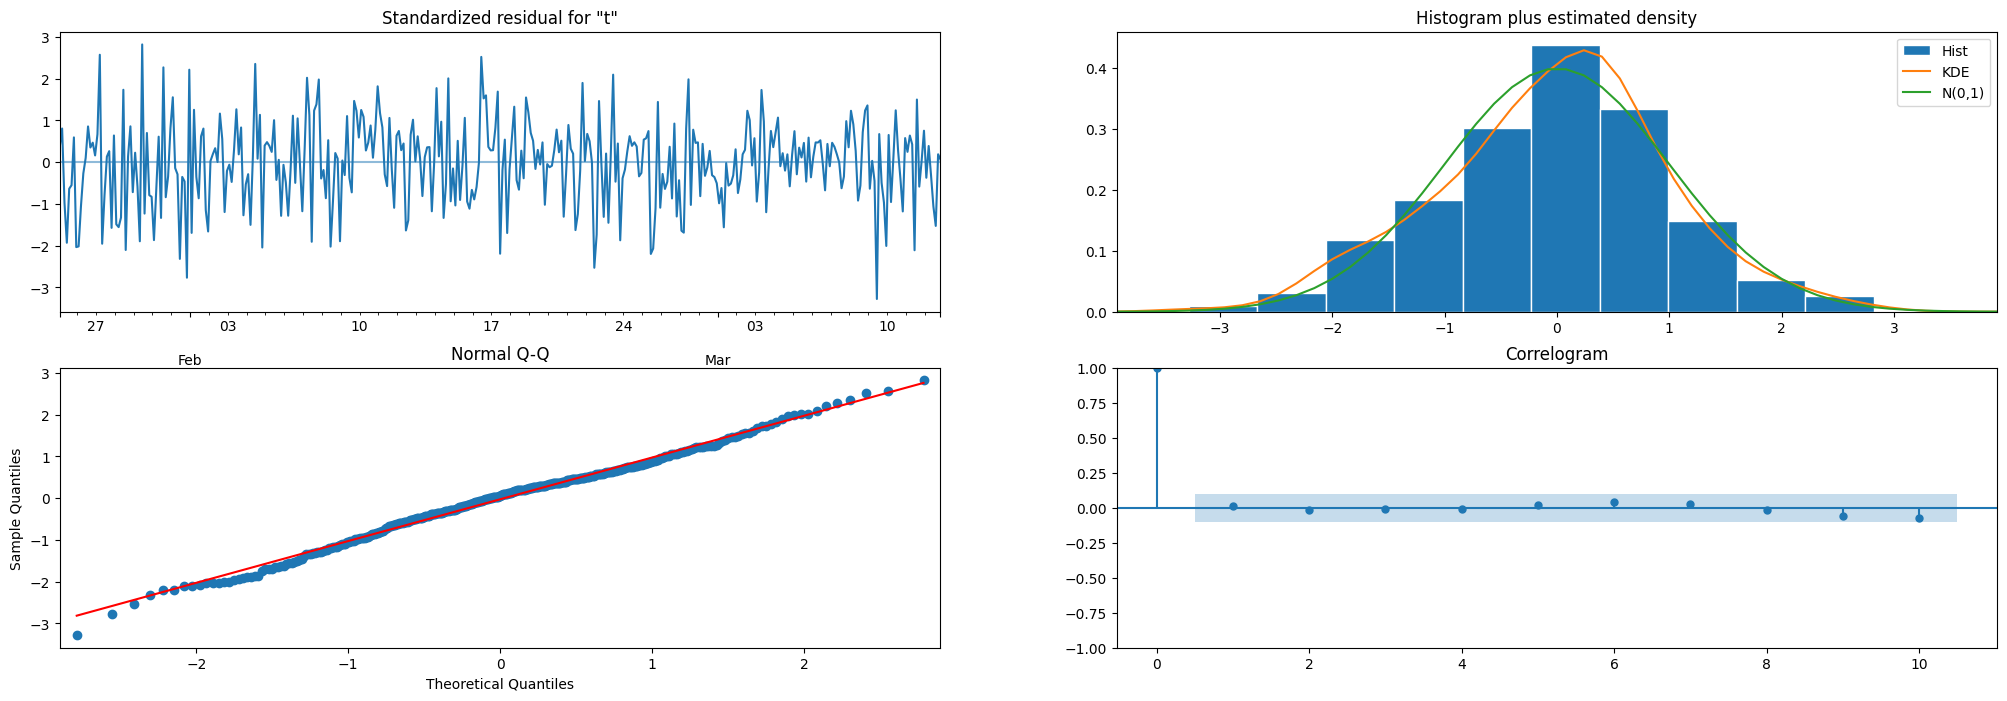

In [99]:
residuals = best_model_sarimax.resid
best_model_sarimax.plot_diagnostics();

*Les résidus sont en grande partie bien répartis et non autocorrélés, ce qui indique que ton modèle capte bien la structure des données.*

Comparer les performances des modèles sur des métriques adaptées.

*Nous avons utiliser le mean_absolute_percentage_error pour les modèles statistiques et le r2_score pour les modèles de machines learning.*